# Rotary Inverted Pendulum - Balance Session Analysis

This notebook analyzes telemetry data from balance sessions to visualize system behavior and debug control performance.

**Data Source:** `logs/balance/session_*/balance_log.csv`

In [23]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from scipy import signal

# Configure plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Load Data

Select the most recent session or specify a session directory manually.

In [24]:
# Find all balance sessions
log_dir = Path('../logs/balance')
sessions = sorted(log_dir.glob('session_*'), reverse=True)

if not sessions:
    print("⚠ No balance sessions found in logs/balance/")
else:
    print(f"Found {len(sessions)} sessions:")
    for i, session in enumerate(sessions[:10]):
        print(f"  {i}: {session.name}")
    
    # Load most recent session by default
    session_idx = 0  # Change this to load a different session
    session_path = sessions[session_idx]
    csv_file = session_path / 'balance_log.csv'
    
    if not csv_file.exists():
        print(f"⚠ CSV file not found: {csv_file}")
    else:
        # Load CSV data
        df = pd.read_csv(csv_file)
        
        # Convert timestamp to seconds (relative to start)
        df['time_s'] = (df['timestamp_ms'] - df['timestamp_ms'].iloc[0]) / 1000.0
        
        print(f"\n✓ Loaded: {session_path.name}")
        print(f"  Duration: {df['time_s'].iloc[-1]:.1f} seconds")
        print(f"  Samples: {len(df)}")
        print(f"\nData columns:")
        print(df.columns.tolist())
        print(f"\nFirst few rows:")
        display(df.head())

Found 13 sessions:
  0: session_20260123_110508
  1: session_20260123_110425
  2: session_20260122_124410
  3: session_20260122_124149
  4: session_20260122_122932
  5: session_20260122_121124
  6: session_20260122_112057
  7: session_20260122_104140
  8: session_20260122_103804
  9: session_20260122_103656

✓ Loaded: session_20260123_110508
  Duration: 2.4 seconds
  Samples: 123

Data columns:
['timestamp_ms', 'alpha_deg', 'alpha_dot_deg_s', 'theta_deg', 'theta_dot_deg_s', 'acc_cmd_steps_s2', 'vel_cmd_steps_s', 'pos_meas_steps', 'position_clamped', 'time_s']

First few rows:


,timestamp_ms,alpha_deg,alpha_dot_deg_s,theta_deg,theta_dot_deg_s,acc_cmd_steps_s2,vel_cmd_steps_s,pos_meas_steps,position_clamped,time_s
0,7219,3.69,212.62,-1.93,-103.16,2691,20,-8,0,0.000
1,7238,4.30,-26.27,-2.10,13.51,989,78,-9,0,0.019
2,7259,2.37,-17.58,-1.23,9.85,770,48,-5,0,0.040
3,7279,3.51,0.70,-1.40,12.75,2929,132,-6,0,0.060
4,7299,1.93,-35.12,-0.61,23.75,374,109,-2,0,0.080


## 2. Session Overview

Quick statistics and sanity checks.

In [25]:
print("=" * 60)
print("SESSION STATISTICS")
print("=" * 60)

print(f"\nPendulum Angle (alpha):")
print(f"  Mean:  {df['alpha_deg'].mean():7.2f}°")
print(f"  Std:   {df['alpha_deg'].std():7.2f}°")
print(f"  Range: [{df['alpha_deg'].min():7.2f}, {df['alpha_deg'].max():7.2f}]°")

print(f"\nBase Position (theta):")
print(f"  Mean:  {df['theta_deg'].mean():7.2f}°")
print(f"  Std:   {df['theta_deg'].std():7.2f}°")
print(f"  Range: [{df['theta_deg'].min():7.2f}, {df['theta_deg'].max():7.2f}]°")

print(f"\nControl Commands:")
print(f"  Acc cmd range: [{df['acc_cmd_steps_s2'].min():6.0f}, {df['acc_cmd_steps_s2'].max():6.0f}] steps/s²")
print(f"  Vel cmd range: [{df['vel_cmd_steps_s'].min():6.0f}, {df['vel_cmd_steps_s'].max():6.0f}] steps/s")

print(f"\nPosition Limits:")
clamped_pct = (df['position_clamped'].sum() / len(df)) * 100
print(f"  Clamped: {clamped_pct:.1f}% of time")
if clamped_pct > 5:
    print(f"  ⚠ WARNING: Spent >5% of time near limits!")

print("\n" + "=" * 60)

SESSION STATISTICS

Pendulum Angle (alpha):
  Mean:    -1.33°
  Std:      5.89°
  Range: [ -27.24,   21.62]°

Base Position (theta):
  Mean:     4.32°
  Std:     12.62°
  Range: [ -76.55,   10.63]°

Control Commands:
  Acc cmd range: [-20000,  20000] steps/s²
  Vel cmd range: [ -2850,    215] steps/s

Position Limits:
  Clamped: 0.0% of time



## 3. Time Series Plots

### 3.1 Pendulum States

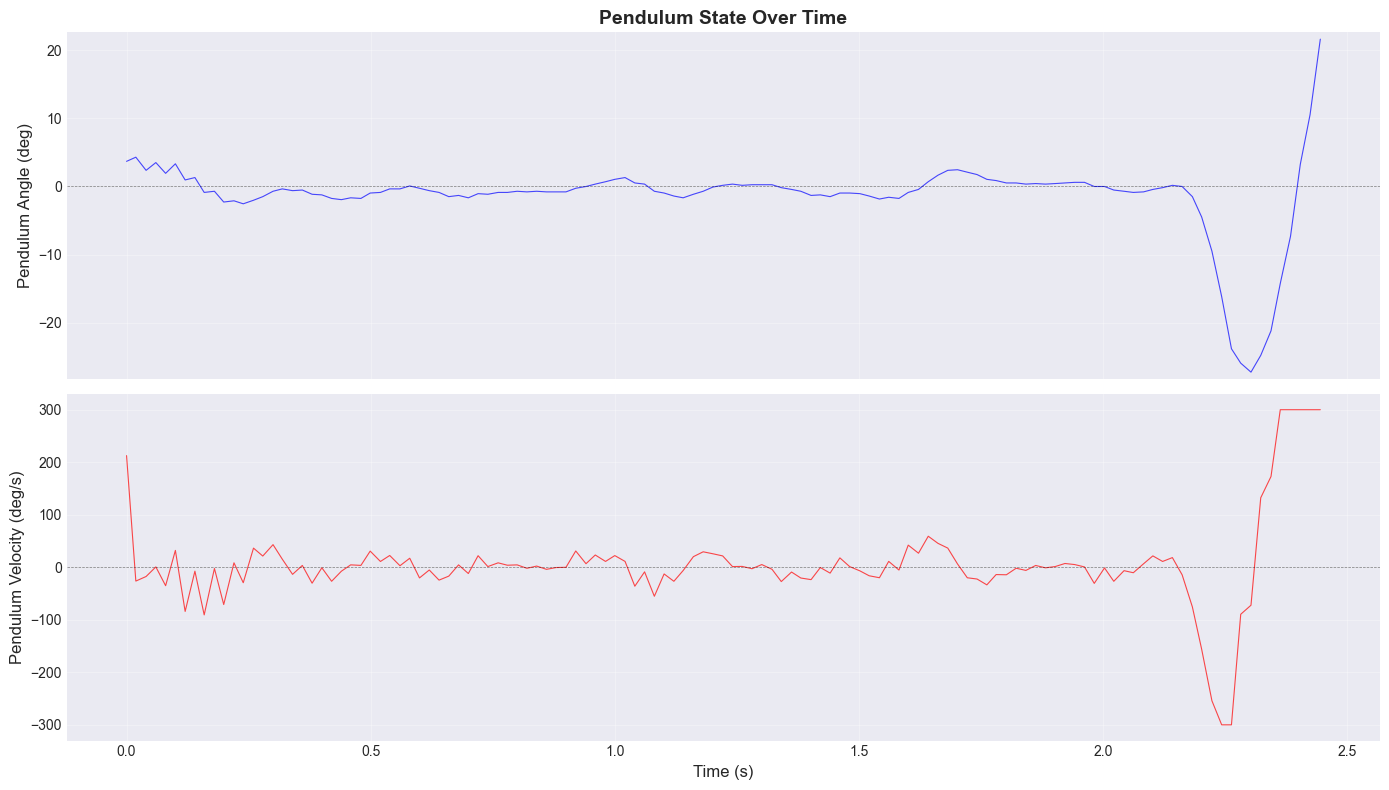

Pendulum stability: α_rms = 6.01°


In [26]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Pendulum angle
axes[0].plot(df['time_s'], df['alpha_deg'], 'b-', linewidth=0.8, alpha=0.7)
axes[0].axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[0].set_ylabel('Pendulum Angle (deg)', fontsize=12)
axes[0].set_title('Pendulum State Over Time', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([df['alpha_deg'].min() - 1, df['alpha_deg'].max() + 1])

# Pendulum angular velocity
axes[1].plot(df['time_s'], df['alpha_dot_deg_s'], 'r-', linewidth=0.8, alpha=0.7)
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[1].set_ylabel('Pendulum Velocity (deg/s)', fontsize=12)
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Pendulum stability: α_rms = {np.sqrt(np.mean(df['alpha_deg']**2)):.2f}°")

### 3.2 Base (Rotary Arm) States

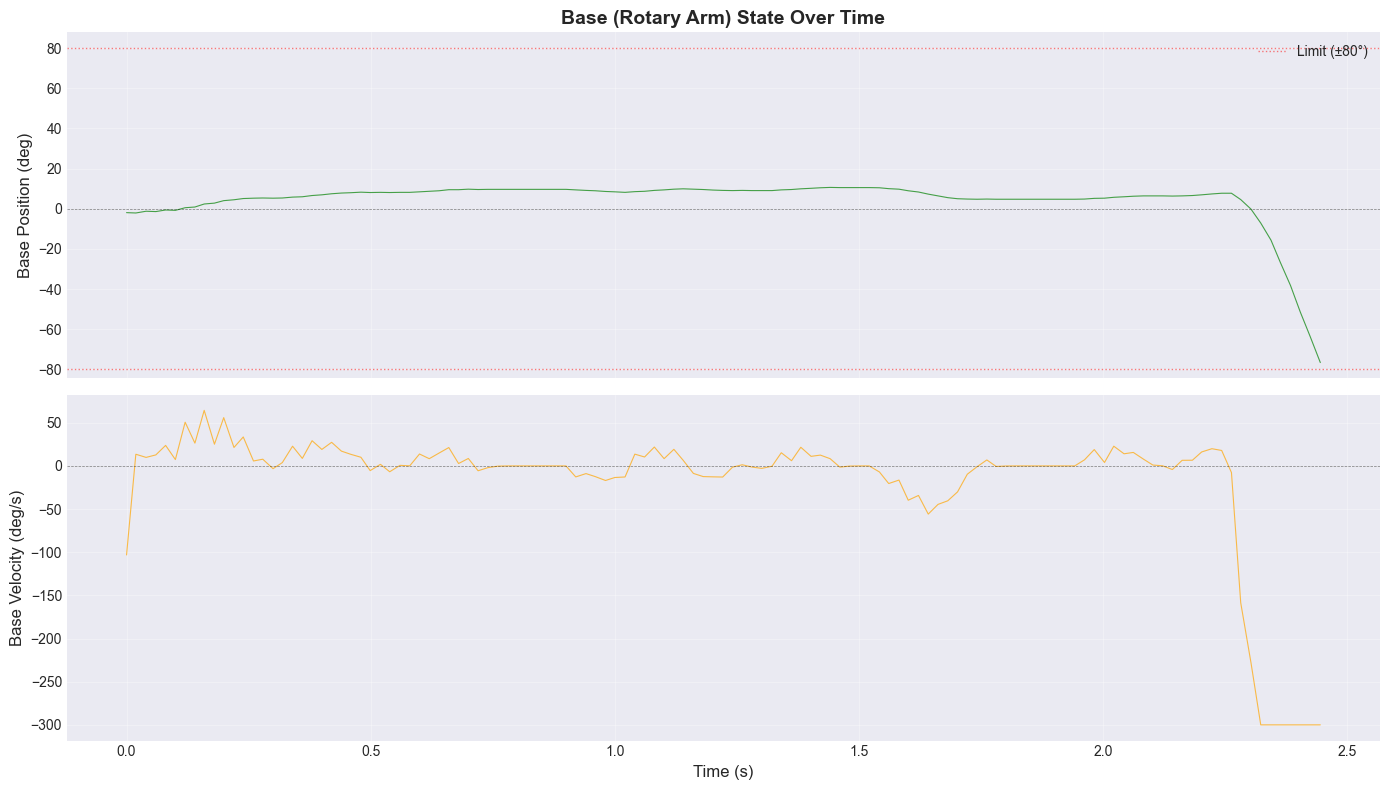

Base centering: θ_mean = 4.32°, θ_std = 12.62°


In [27]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Base position
axes[0].plot(df['time_s'], df['theta_deg'], 'g-', linewidth=0.8, alpha=0.7)
axes[0].axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[0].axhline(y=80, color='r', linestyle=':', linewidth=1, alpha=0.5, label='Limit (±80°)')
axes[0].axhline(y=-80, color='r', linestyle=':', linewidth=1, alpha=0.5)
axes[0].set_ylabel('Base Position (deg)', fontsize=12)
axes[0].set_title('Base (Rotary Arm) State Over Time', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Base velocity
axes[1].plot(df['time_s'], df['theta_dot_deg_s'], 'orange', linewidth=0.8, alpha=0.7)
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[1].set_ylabel('Base Velocity (deg/s)', fontsize=12)
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Base centering: θ_mean = {df['theta_deg'].mean():.2f}°, θ_std = {df['theta_deg'].std():.2f}°")

### 3.3 Control Commands

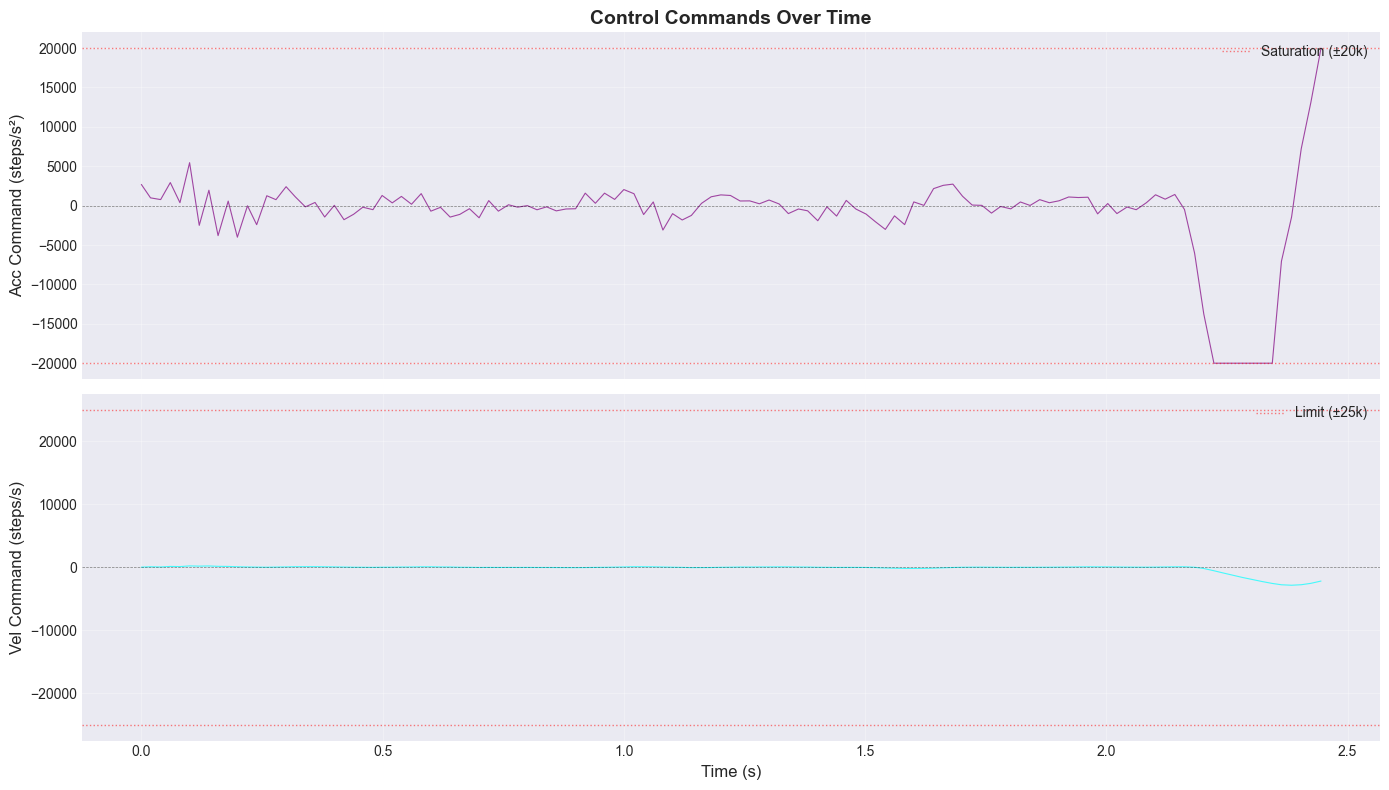

Saturation events: Acc=8 (6.5%), Vel=0 (0.0%)


In [28]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Acceleration command
axes[0].plot(df['time_s'], df['acc_cmd_steps_s2'], 'purple', linewidth=0.8, alpha=0.7)
axes[0].axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[0].axhline(y=20000, color='r', linestyle=':', linewidth=1, alpha=0.5, label='Saturation (±20k)')
axes[0].axhline(y=-20000, color='r', linestyle=':', linewidth=1, alpha=0.5)
axes[0].set_ylabel('Acc Command (steps/s²)', fontsize=12)
axes[0].set_title('Control Commands Over Time', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Velocity command
axes[1].plot(df['time_s'], df['vel_cmd_steps_s'], 'cyan', linewidth=0.8, alpha=0.7)
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[1].axhline(y=25000, color='r', linestyle=':', linewidth=1, alpha=0.5, label='Limit (±25k)')
axes[1].axhline(y=-25000, color='r', linestyle=':', linewidth=1, alpha=0.5)
axes[1].set_ylabel('Vel Command (steps/s)', fontsize=12)
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check saturation
acc_sat = (np.abs(df['acc_cmd_steps_s2']) >= 19900).sum()
vel_sat = (np.abs(df['vel_cmd_steps_s']) >= 24900).sum()
print(f"Saturation events: Acc={acc_sat} ({acc_sat/len(df)*100:.1f}%), Vel={vel_sat} ({vel_sat/len(df)*100:.1f}%)")

## 4. Phase Portraits

Visualize state-space trajectories to assess stability.

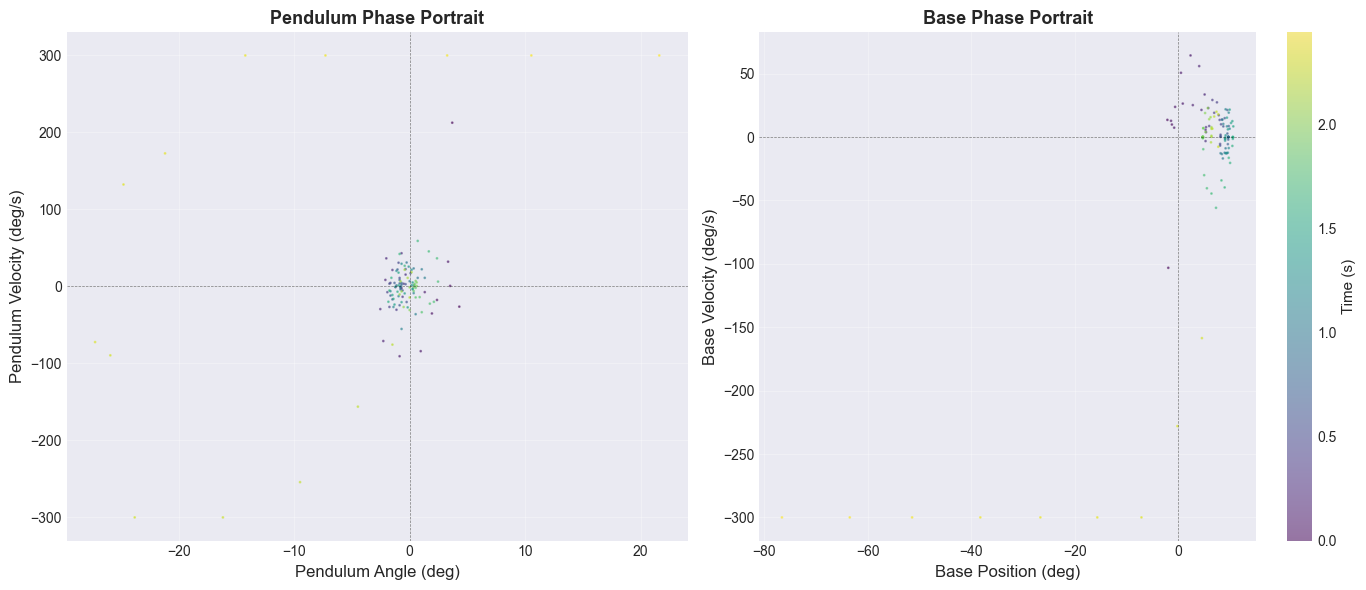

Phase portraits show trajectory through state space.
  - Tight spiral → converging to equilibrium (stable)
  - Expanding spiral → diverging (unstable)
  - Limit cycle → sustained oscillation


In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pendulum phase portrait
axes[0].scatter(df['alpha_deg'], df['alpha_dot_deg_s'], c=df['time_s'], 
                cmap='viridis', s=1, alpha=0.5)
axes[0].axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[0].axvline(x=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[0].set_xlabel('Pendulum Angle (deg)', fontsize=12)
axes[0].set_ylabel('Pendulum Velocity (deg/s)', fontsize=12)
axes[0].set_title('Pendulum Phase Portrait', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Base phase portrait
scatter = axes[1].scatter(df['theta_deg'], df['theta_dot_deg_s'], c=df['time_s'], 
                          cmap='viridis', s=1, alpha=0.5)
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[1].axvline(x=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[1].set_xlabel('Base Position (deg)', fontsize=12)
axes[1].set_ylabel('Base Velocity (deg/s)', fontsize=12)
axes[1].set_title('Base Phase Portrait', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Time (s)', fontsize=11)

plt.tight_layout()
plt.show()

print("Phase portraits show trajectory through state space.")
print("  - Tight spiral → converging to equilibrium (stable)")
print("  - Expanding spiral → diverging (unstable)")
print("  - Limit cycle → sustained oscillation")

## 5. Frequency Analysis

Identify oscillation frequencies and resonances.

Sampling rate: 50.0 Hz (dt=20.0ms)


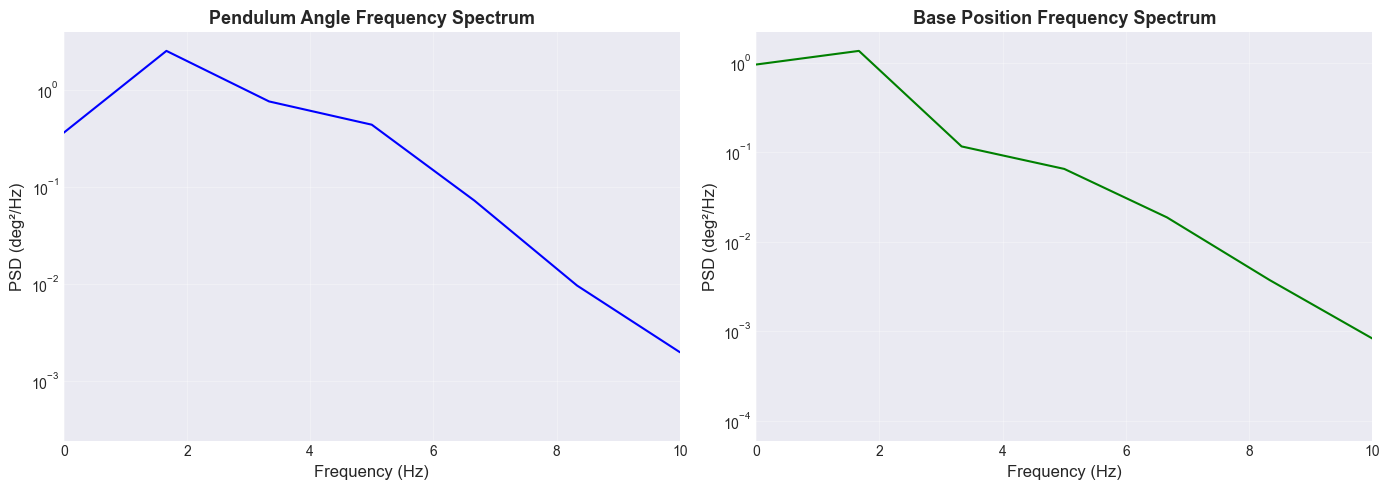


Dominant oscillation frequencies:
  Pendulum: 1.67 Hz
  Base:     1.67 Hz


In [30]:
# Compute sampling rate
dt = np.median(np.diff(df['time_s']))
fs = 1.0 / dt
print(f"Sampling rate: {fs:.1f} Hz (dt={dt*1000:.1f}ms)")

# Compute FFT for pendulum angle (convert to numpy arrays)
freqs_alpha, psd_alpha = signal.welch(df['alpha_deg'].values, fs=fs, nperseg=min(512, len(df)//4))
freqs_theta, psd_theta = signal.welch(df['theta_deg'].values, fs=fs, nperseg=min(512, len(df)//4))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pendulum angle spectrum
axes[0].semilogy(freqs_alpha, psd_alpha, 'b-', linewidth=1.5)
axes[0].set_xlabel('Frequency (Hz)', fontsize=12)
axes[0].set_ylabel('PSD (deg²/Hz)', fontsize=12)
axes[0].set_title('Pendulum Angle Frequency Spectrum', fontsize=13, fontweight='bold')
axes[0].set_xlim([0, 10])  # Focus on low frequencies
axes[0].grid(True, alpha=0.3)

# Base position spectrum
axes[1].semilogy(freqs_theta, psd_theta, 'g-', linewidth=1.5)
axes[1].set_xlabel('Frequency (Hz)', fontsize=12)
axes[1].set_ylabel('PSD (deg²/Hz)', fontsize=12)
axes[1].set_title('Base Position Frequency Spectrum', fontsize=13, fontweight='bold')
axes[1].set_xlim([0, 10])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find dominant frequencies
idx_alpha = np.argmax(psd_alpha[freqs_alpha > 0.1])
idx_theta = np.argmax(psd_theta[freqs_theta > 0.1])
peak_freq_alpha = freqs_alpha[freqs_alpha > 0.1][idx_alpha]
peak_freq_theta = freqs_theta[freqs_theta > 0.1][idx_theta]

print(f"\nDominant oscillation frequencies:")
print(f"  Pendulum: {peak_freq_alpha:.2f} Hz")
print(f"  Base:     {peak_freq_theta:.2f} Hz")

## 6. Full State Visualization

Combined plot showing all four states simultaneously.

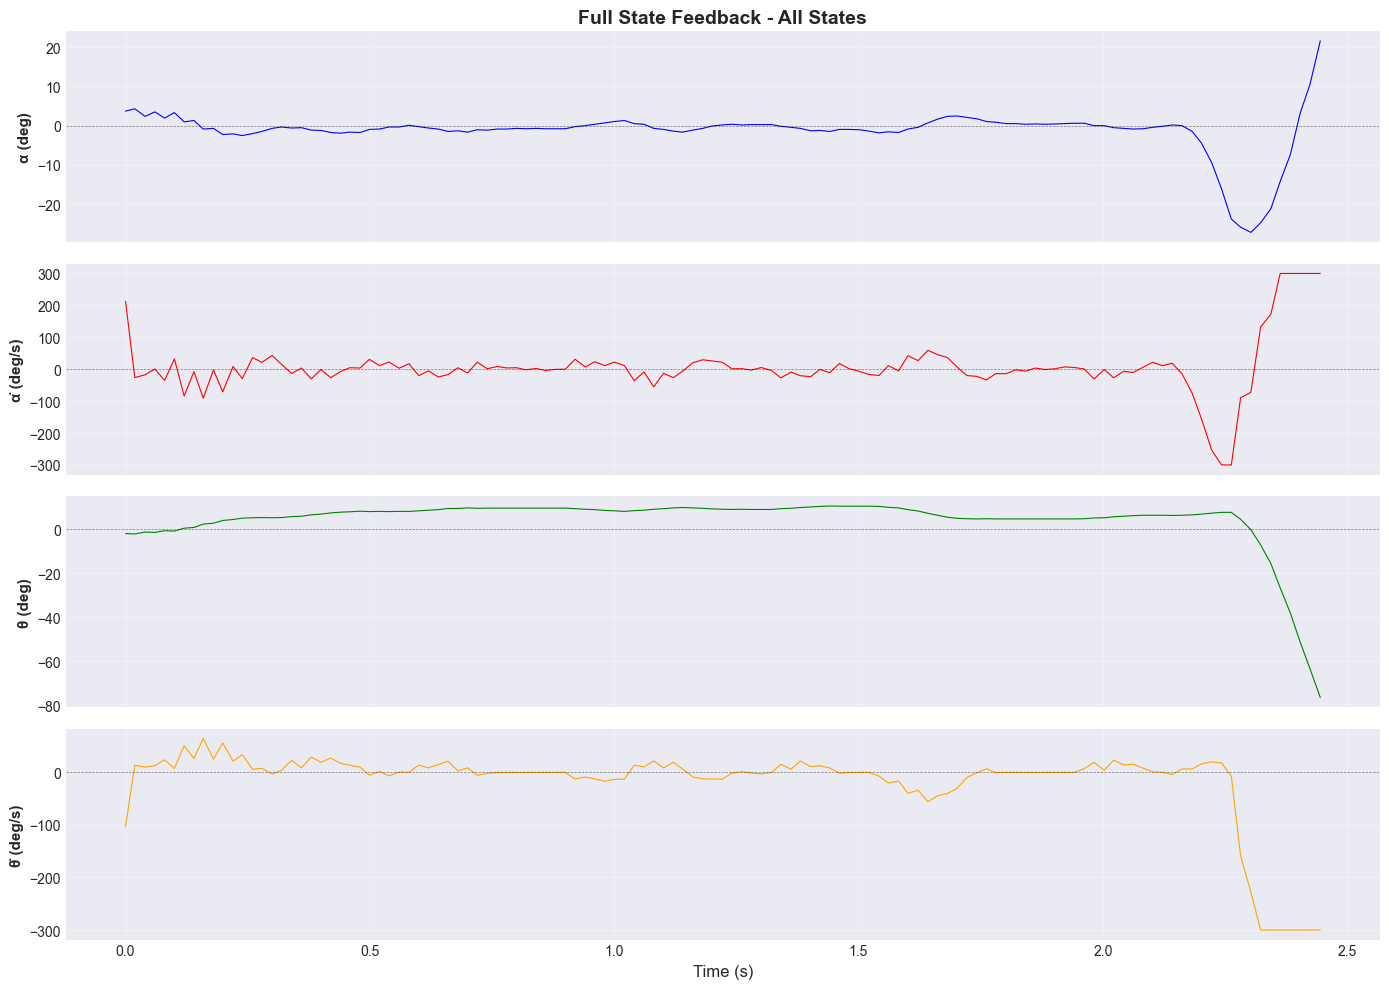

Full state vector: x = [θ, α, θ̇, α̇]ᵀ
Control law: u = K₁θ + K₂α + K₃θ̇ + K₄α̇


In [31]:
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Alpha
axes[0].plot(df['time_s'], df['alpha_deg'], 'b-', linewidth=0.8)
axes[0].axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[0].set_ylabel('α (deg)', fontsize=11, fontweight='bold')
axes[0].set_title('Full State Feedback - All States', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Alpha dot
axes[1].plot(df['time_s'], df['alpha_dot_deg_s'], 'r-', linewidth=0.8)
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[1].set_ylabel('α̇ (deg/s)', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Theta
axes[2].plot(df['time_s'], df['theta_deg'], 'g-', linewidth=0.8)
axes[2].axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[2].set_ylabel('θ (deg)', fontsize=11, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Theta dot
axes[3].plot(df['time_s'], df['theta_dot_deg_s'], 'orange', linewidth=0.8)
axes[3].axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[3].set_ylabel('θ̇ (deg/s)', fontsize=11, fontweight='bold')
axes[3].set_xlabel('Time (s)', fontsize=12)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Full state vector: x = [θ, α, θ̇, α̇]ᵀ")
print("Control law: u = K₁θ + K₂α + K₃θ̇ + K₄α̇")

## 7. Performance Metrics

Quantitative assessment of controller performance.

In [32]:
# Compute performance metrics
metrics = {
    'RMS Pendulum Error': np.sqrt(np.mean(df['alpha_deg']**2)),
    'Max Pendulum Deviation': np.abs(df['alpha_deg']).max(),
    'RMS Base Position': np.sqrt(np.mean(df['theta_deg']**2)),
    'Max Base Excursion': np.abs(df['theta_deg']).max(),
    'Mean Control Effort (Acc)': np.abs(df['acc_cmd_steps_s2']).mean(),
    'Mean Control Effort (Vel)': np.abs(df['vel_cmd_steps_s']).mean(),
    'Saturation Time (%)': (np.abs(df['acc_cmd_steps_s2']) >= 19900).sum() / len(df) * 100,
}

print("=" * 60)
print("PERFORMANCE METRICS")
print("=" * 60)
for metric, value in metrics.items():
    print(f"  {metric:30s}: {value:8.2f}")
print("=" * 60)

# Assessment
print("\nASSESSMENT:")
if metrics['RMS Pendulum Error'] < 2.0:
    print("  ✓ Excellent pendulum stabilization (RMS < 2°)")
elif metrics['RMS Pendulum Error'] < 5.0:
    print("  ✓ Good pendulum stabilization (RMS < 5°)")
else:
    print("  ⚠ Pendulum stabilization needs improvement (RMS > 5°)")

if metrics['RMS Base Position'] < 10.0:
    print("  ✓ Good base centering (RMS < 10°)")
elif metrics['RMS Base Position'] < 30.0:
    print("  ⚠ Base drifts moderately (RMS < 30°)")
else:
    print("  ✗ Significant base drift (RMS > 30°) - increase K_THETA")

if metrics['Saturation Time (%)'] < 5:
    print("  ✓ Low saturation (< 5% of time)")
else:
    print(f"  ⚠ High saturation ({metrics['Saturation Time (%)']:.1f}% of time)")

PERFORMANCE METRICS
  RMS Pendulum Error            :     6.01
  Max Pendulum Deviation        :    27.24
  RMS Base Position             :    13.29
  Max Base Excursion            :    76.55
  Mean Control Effort (Acc)     :  2642.80
  Mean Control Effort (Vel)     :   244.80
  Saturation Time (%)           :     6.50

ASSESSMENT:
  ⚠ Pendulum stabilization needs improvement (RMS > 5°)
  ⚠ Base drifts moderately (RMS < 30°)
  ⚠ High saturation (6.5% of time)


## 8. Settling Time Analysis

How quickly does the system converge after engagement?

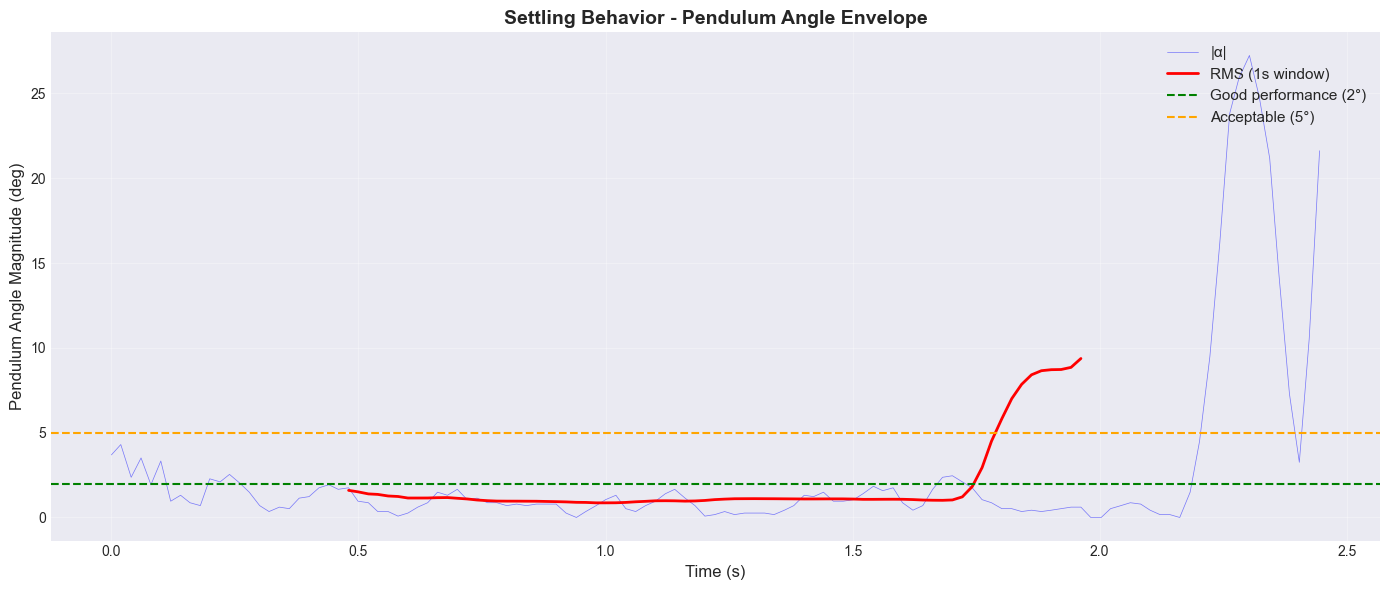

⚠ System did not settle within session (RMS never stayed below 2.0° for 3.0s)


In [33]:
# Compute envelope of alpha (pendulum angle)
window_size = int(1.0 / dt)  # 1-second rolling window
alpha_rms_rolling = df['alpha_deg'].rolling(window=window_size, center=True).apply(lambda x: np.sqrt(np.mean(x**2)))

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df['time_s'], np.abs(df['alpha_deg']), 'b-', linewidth=0.5, alpha=0.5, label='|α|')
ax.plot(df['time_s'], alpha_rms_rolling, 'r-', linewidth=2, label='RMS (1s window)')
ax.axhline(y=2.0, color='g', linestyle='--', linewidth=1.5, label='Good performance (2°)')
ax.axhline(y=5.0, color='orange', linestyle='--', linewidth=1.5, label='Acceptable (5°)')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Pendulum Angle Magnitude (deg)', fontsize=12)
ax.set_title('Settling Behavior - Pendulum Angle Envelope', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find settling time (when RMS stays below 2° for 3 seconds)
threshold = 2.0
settle_duration = 3.0  # seconds
settle_samples = int(settle_duration / dt)

settled = False
settle_time = None
for i in range(len(alpha_rms_rolling) - settle_samples):
    if np.all(alpha_rms_rolling.iloc[i:i+settle_samples] < threshold):
        settle_time = df['time_s'].iloc[i]
        settled = True
        break

if settled:
    print(f"✓ System settled in {settle_time:.1f} seconds (RMS < {threshold}° for {settle_duration}s)")
else:
    print(f"⚠ System did not settle within session (RMS never stayed below {threshold}° for {settle_duration}s)")

## 9. Export Summary Report

Save key metrics and plots for documentation.

In [34]:
# Create summary report
report_path = session_path / 'analysis_summary.txt'

with open(report_path, 'w') as f:
    f.write("=" * 60 + "\n")
    f.write(f"BALANCE SESSION ANALYSIS SUMMARY\n")
    f.write("=" * 60 + "\n\n")
    
    f.write(f"Session: {session_path.name}\n")
    f.write(f"Duration: {df['time_s'].iloc[-1]:.1f} seconds\n")
    f.write(f"Samples: {len(df)}\n\n")
    
    f.write("PERFORMANCE METRICS:\n")
    f.write("-" * 60 + "\n")
    for metric, value in metrics.items():
        f.write(f"  {metric:30s}: {value:8.2f}\n")
    f.write("\n")
    
    f.write("FREQUENCY ANALYSIS:\n")
    f.write("-" * 60 + "\n")
    f.write(f"  Pendulum dominant freq: {peak_freq_alpha:.2f} Hz\n")
    f.write(f"  Base dominant freq:     {peak_freq_theta:.2f} Hz\n")
    f.write("\n")
    
    if settled:
        f.write(f"SETTLING TIME: {settle_time:.1f} seconds\n")
    else:
        f.write(f"SETTLING TIME: Did not settle within session\n")

print(f"✓ Analysis summary saved to: {report_path}")
print("\nDone! All plots generated successfully.")

✓ Analysis summary saved to: ../logs/balance/session_20260123_110508/analysis_summary.txt

Done! All plots generated successfully.



📊 Analyzing 4 most recent sessions:
  • Session 1: session_20260129_121640
  • Session 2: session_20260129_121550
  • Session 3: session_20260129_121514
  • Session 4: session_20260129_121349
Loading logs...

--- PERFORMANCE METRICS ---
                                    Survival Time (s)  Noise (Acc StdDev)  \
Label                                                                       
Session 1: session_20260129_121640             15.666         3615.367872   
Session 2: session_20260129_121550              7.620         5717.988488   
Session 3: session_20260129_121514             14.394         5622.545545   
Session 4: session_20260129_121349             22.639         3049.249060   

                                    Max Theta (deg)  Stability (Alpha Var)  
Label                                                                       
Session 1: session_20260129_121640            55.01               8.219308  
Session 2: session_20260129_121550            51.24              26.

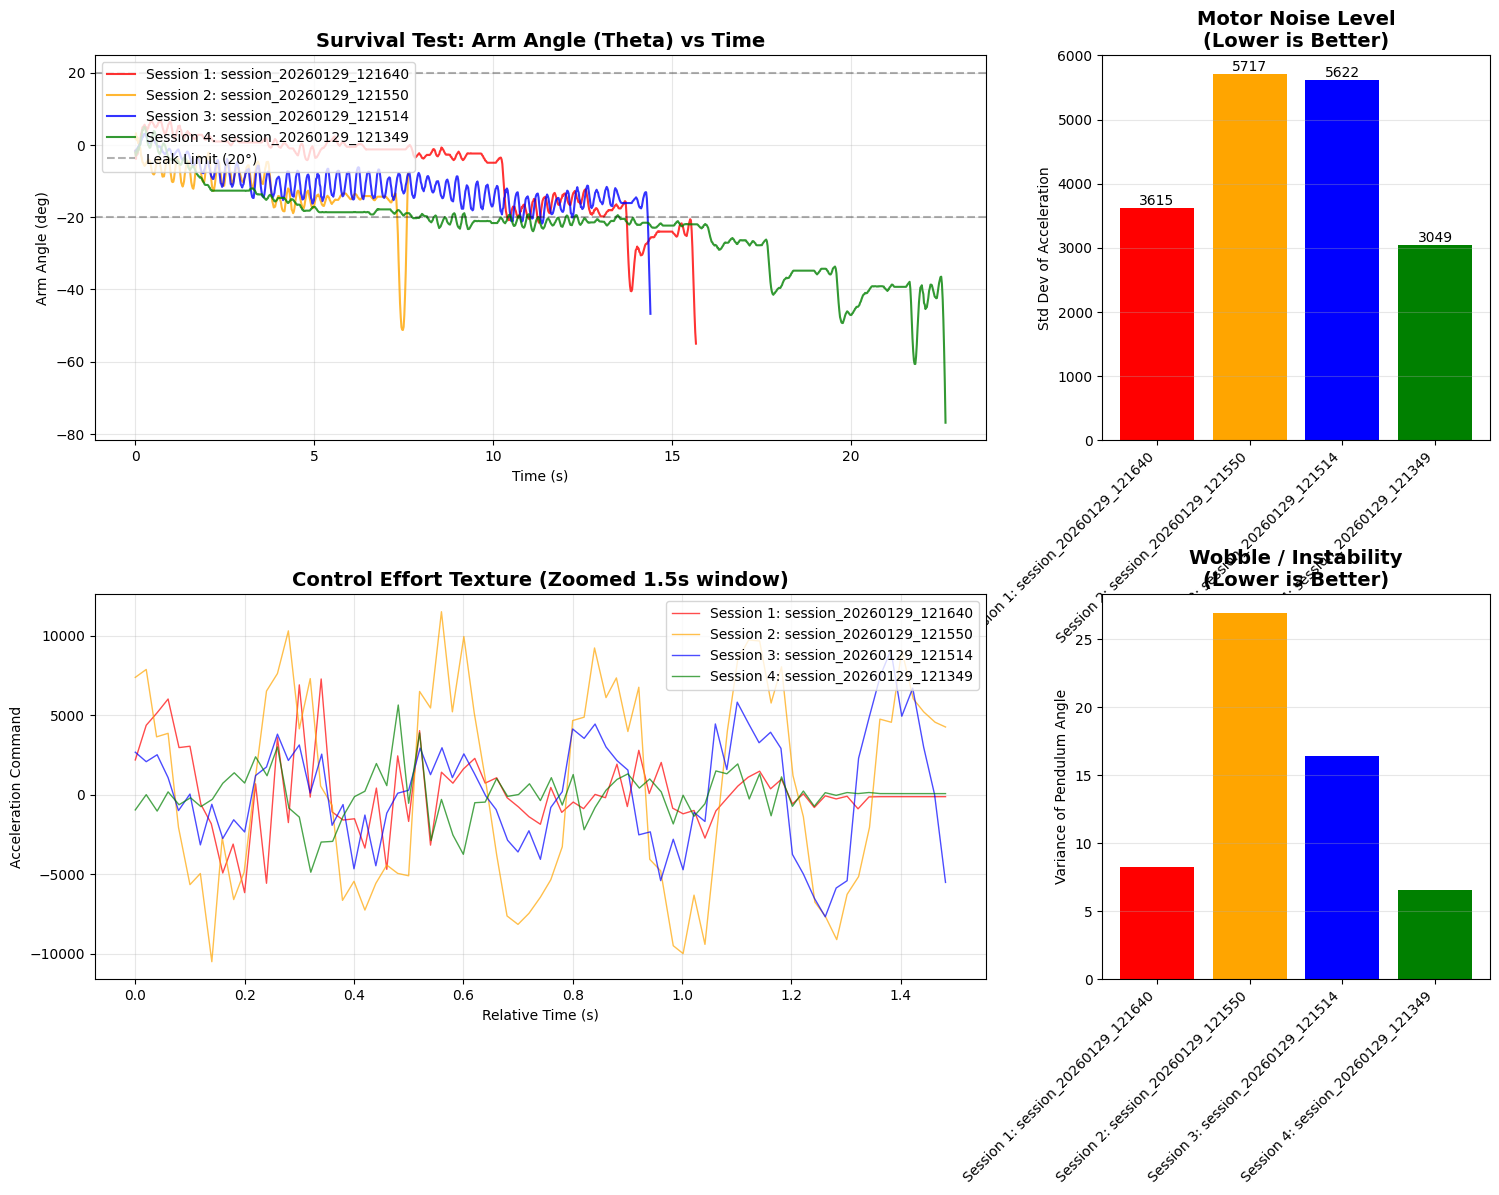

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

# --- CONFIGURATION ---
# How many most recent sessions to analyze?
N_SESSIONS = 4  # Changethis to analyze more/fewer sessions

# Automatically find the N most recent balance sessions
log_dir = Path('../logs/balance')
sessions = sorted(log_dir.glob('session_*'), reverse=True)[:N_SESSIONS]

if len(sessions) < N_SESSIONS:
    print(f"⚠ Warning: Found only {len(sessions)} sessions, requested {N_SESSIONS}")

# Build LOG_FILES dict dynamically
LOG_FILES = {}
for i, session_path in enumerate(sessions):
    csv_file = session_path / 'balance_log.csv'
    if csv_file.exists():
        # Extract omega_c from session if possible, or use session name
        label = f"Session {i+1}: {session_path.name}"
        LOG_FILES[label] = str(csv_file)
    else:
        print(f"⚠ Skipping {session_path.name}: no balance_log.csv found")

if not LOG_FILES:
    print("✗ No valid sessions found. Make sure you have balance_log.csv files.")
    print("  Expected location: logs/balance/session_*/balance_log.csv")

# Auto-generate colors
color_cycle = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'pink', 'gray']
COLORS = {label: color_cycle[i % len(color_cycle)] for i, label in enumerate(LOG_FILES.keys())}

print(f"\n📊 Analyzing {len(LOG_FILES)} most recent sessions:")
for label in LOG_FILES.keys():
    print(f"  • {label}")

def load_and_clean(filepath, label):
    if not os.path.exists(filepath):
        print(f"Warning: File {filepath} not found. Skipping.")
        return None
    
    try:
        df = pd.read_csv(filepath)
        # Normalize time to start at 0
        df['t_sec'] = (df['timestamp_ms'] - df['timestamp_ms'].iloc[0]) / 1000.0
        df['Label'] = label
        return df
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

def calculate_metrics(df):
    return {
        'Survival Time (s)': df['t_sec'].max(),
        'Noise (Acc StdDev)': df['acc_cmd_steps_s2'].std(),
        'Max Theta (deg)': df['theta_deg'].abs().max(),
        'Stability (Alpha Var)': df['alpha_deg'].var()
    }

# --- MAIN EXECUTION ---
data_store = {}
metrics_list = []

print("Loading logs...")
for label, fname in LOG_FILES.items():
    df = load_and_clean(fname, label)
    if df is not None:
        data_store[label] = df
        m = calculate_metrics(df)
        m['Label'] = label
        metrics_list.append(m)

if not data_store:
    print("No data loaded. Exiting.")
    exit()

metrics_df = pd.DataFrame(metrics_list).set_index('Label')
print("\n--- PERFORMANCE METRICS ---")
print(metrics_df)

# --- PLOTTING ---
fig = plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. SURVIVAL PLOT (Theta vs Time)
# Shows how long each survived and how far it went
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
for label, df in data_store.items():
    ax1.plot(df['t_sec'], df['theta_deg'], label=label, color=COLORS[label], linewidth=1.5, alpha=0.8)
ax1.axhline(20, color='k', linestyle='--', alpha=0.3, label='Leak Limit (20°)')
ax1.axhline(-20, color='k', linestyle='--', alpha=0.3)
ax1.set_title("Survival Test: Arm Angle (Theta) vs Time", fontsize=14, fontweight='bold')
ax1.set_ylabel("Arm Angle (deg)")
ax1.set_xlabel("Time (s)")
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. NOISE PLOT (Bar Chart)
# Shows which filter is quietest
ax2 = plt.subplot2grid((2, 3), (0, 2))
bars = ax2.bar(metrics_df.index, metrics_df['Noise (Acc StdDev)'], color=[COLORS[l] for l in metrics_df.index])
ax2.set_title("Motor Noise Level\n(Lower is Better)", fontsize=14, fontweight='bold')
ax2.set_ylabel("Std Dev of Acceleration")
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
# Add values on top
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

# 3. STABILITY AT EDGE (Alpha Variance)
# How much did it wobble?
ax3 = plt.subplot2grid((2, 3), (1, 2))
# Only consider data where theta > 10 (active balancing) if possible
# Or just use global variance
bars3 = ax3.bar(metrics_df.index, metrics_df['Stability (Alpha Var)'], color=[COLORS[l] for l in metrics_df.index])
ax3.set_title("Wobble / Instability\n(Lower is Better)", fontsize=14, fontweight='bold')
ax3.set_ylabel("Variance of Pendulum Angle")
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# 4. CONTROL EFFORT (Zoomed In)
# Shows the "Texture" of the control signal (Buzz vs Smooth)
ax4 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
for label, df in data_store.items():
    # Take a 1-second slice from the middle of each log to compare "texture"
    # finding a stable region (e.g., 1s to 2s)
    subset = df[(df['t_sec'] > 1.0) & (df['t_sec'] < 2.5)]
    if not subset.empty:
        # Shift time to start at 0 for overlay
        t_shifted = subset['t_sec'] - subset['t_sec'].iloc[0]
        ax4.plot(t_shifted, subset['acc_cmd_steps_s2'], label=label, color=COLORS[label], linewidth=1, alpha=0.7)

ax4.set_title("Control Effort Texture (Zoomed 1.5s window)", fontsize=14, fontweight='bold')
ax4.set_ylabel("Acceleration Command")
ax4.set_xlabel("Relative Time (s)")
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

# Save
plt.savefig('comparison_report.png', dpi=100)
print("\nPlot saved as 'comparison_report.png'")
plt.show()

## 10. Controller Mode Comparison (Linear vs SMC)

This section loads each session’s `balance_log.csv` and `events.txt`, infers controller mode, segments the active balancing window (post‑ENGAGED via control‑activity onset), and compares standard control metrics across modes.

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIGURATION ---
LOG_ROOT = Path('../logs/balance')
MAX_SESSIONS = None  # set to an int to limit, or None for all
SETTLE_THRESHOLD_DEG = 2.0
SETTLE_DURATION_S = 3.0
ROLLING_RMS_WIN_S = 1.0
ACC_THRESH_MIN = 500.0
VEL_THRESH_MIN = 200.0
MAX_PLOT_T = 12.0  # seconds for aligned comparison plots
DT_GRID = 0.02      # resampling grid for overlay plots (50 Hz)

def parse_events(session_path: Path):
    events_path = session_path / 'events.txt'
    mode = None
    engaged = False
    has_move = False
    if not events_path.exists():
        return {'mode': 'UNKNOWN', 'engaged': False, 'has_move': False}
    
    with open(events_path, 'r') as f:
        for line in f:
            if 'mode=SMC' in line:
                mode = 'SMC'
            elif 'mode=LIN' in line:
                mode = 'LIN'
            if 'ENGAGED' in line:
                engaged = True
            if '[MOVE]' in line or 'thetaTargetDeg=' in line:
                has_move = True
    
    if mode is None:
        mode = 'UNKNOWN'
    return {'mode': mode, 'engaged': engaged, 'has_move': has_move}

def detect_active_start(df: pd.DataFrame):
    if len(df) < 5:
        return 0
    dt = np.median(np.diff(df['time_s']))
    win = max(3, int(0.3 / dt))
    acc_abs = df['acc_cmd_steps_s2'].abs().rolling(win, center=True).mean()
    vel_abs = df['vel_cmd_steps_s'].abs().rolling(win, center=True).mean()
    acc_th = max(ACC_THRESH_MIN, 0.05 * acc_abs.max())
    vel_th = max(VEL_THRESH_MIN, 0.05 * vel_abs.max())
    active_mask = (acc_abs > acc_th) | (vel_abs > vel_th)
    idx = np.argmax(active_mask.values) if active_mask.any() else 0
    return int(idx)

def rolling_rms(series: pd.Series, win_s: float, dt: float):
    win = max(3, int(win_s / dt))
    return series.rolling(window=win, center=True).apply(lambda x: np.sqrt(np.mean(x**2)))

def compute_settle_time(df_seg: pd.DataFrame):
    if len(df_seg) < 5:
        return np.nan
    dt = np.median(np.diff(df_seg['time_s']))
    rms = rolling_rms(df_seg['alpha_deg'], ROLLING_RMS_WIN_S, dt)
    settle_samples = int(SETTLE_DURATION_S / dt)
    for i in range(len(rms) - settle_samples):
        if np.all(rms.iloc[i:i + settle_samples] < SETTLE_THRESHOLD_DEG):
            return df_seg['time_s'].iloc[i]
    return np.nan

def compute_metrics(df_seg: pd.DataFrame):
    acc_rms = np.sqrt(np.mean(df_seg['acc_cmd_steps_s2']**2))
    vel_rms = np.sqrt(np.mean(df_seg['vel_cmd_steps_s']**2))
    metrics = {
        'RMS_alpha_deg': np.sqrt(np.mean(df_seg['alpha_deg']**2)),
        'Max_abs_alpha_deg': df_seg['alpha_deg'].abs().max(),
        'RMS_theta_deg': np.sqrt(np.mean(df_seg['theta_deg']**2)),
        'Acc_RMS_steps_s2': acc_rms,
        'Vel_RMS_steps_s': vel_rms,
        'Clamped_pct': 100.0 * df_seg['position_clamped'].mean(),
        'Settle_time_s': compute_settle_time(df_seg),
        'Duration_s': df_seg['time_s'].iloc[-1] if len(df_seg) else 0.0,
    }
    return metrics

# --- LOAD ALL SESSIONS ---
session_paths = sorted(LOG_ROOT.glob('session_*'), reverse=True)
if MAX_SESSIONS is not None:
    session_paths = session_paths[:MAX_SESSIONS]

sessions_data = []
for session_path in session_paths:
    csv_file = session_path / 'balance_log.csv'
    if not csv_file.exists():
        continue
    df = pd.read_csv(csv_file)
    if df.empty:
        continue
    df['time_s'] = (df['timestamp_ms'] - df['timestamp_ms'].iloc[0]) / 1000.0
    meta = parse_events(session_path)
    start_idx = detect_active_start(df)
    df_seg = df.iloc[start_idx:].copy()
    df_seg['time_s'] -= df_seg['time_s'].iloc[0]
    metrics = compute_metrics(df_seg)
    sessions_data.append({
        'session': session_path.name,
        'mode': meta['mode'],
        'engaged_event': meta['engaged'],
        'has_move': meta['has_move'],
        'start_idx': start_idx,
        'df': df_seg,
        **metrics
    })

if not sessions_data:
    print("✗ No sessions found for mode comparison.")
else:
    metrics_df = pd.DataFrame(sessions_data).drop(columns=['df'])
    print("\nController comparison summary (per session):")
    display(metrics_df.sort_values(['mode', 'session']))

    # --- GROUPED SUMMARY TABLE ---
    summary = metrics_df.groupby('mode')[['RMS_alpha_deg','Settle_time_s','Acc_RMS_steps_s2','Vel_RMS_steps_s','Clamped_pct']].agg(['mean','median','std','count'])
    print("\nMode-level summary stats:")
    display(summary)

    # --- METRIC COMPARISON PLOTS ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metric_list = [
        ('RMS_alpha_deg', 'RMS α (deg) ↓'),
        ('Settle_time_s', f'Settle time (s) ↓ (RMS<{SETTLE_THRESHOLD_DEG}°)') ,
        ('Acc_RMS_steps_s2', 'Acc RMS (steps/s²) ↓'),
        ('Vel_RMS_steps_s', 'Vel RMS (steps/s) ↓'),
    ]
    for ax, (col, title) in zip(axes.flatten(), metric_list):
        data = [metrics_df[metrics_df['mode'] == m][col].dropna() for m in metrics_df['mode'].unique()]
        labels = list(metrics_df['mode'].unique())
        ax.boxplot(data, labels=labels, showmeans=True)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- ALIGNED TIME-SERIES OVERLAY (α) ---
    t_grid = np.arange(0.0, MAX_PLOT_T + DT_GRID, DT_GRID)
    fig, ax = plt.subplots(figsize=(14, 6))
    for mode in metrics_df['mode'].unique():
        mode_sessions = [s for s in sessions_data if s['mode'] == mode]
        if not mode_sessions:
            continue
        curves = []
        for s in mode_sessions:
            df_seg = s['df']
            t = df_seg['time_s'].values
            y = df_seg['alpha_deg'].values
            if len(t) < 2:
                continue
            t_clip = t[t <= MAX_PLOT_T]
            y_clip = y[:len(t_clip)]
            if len(t_clip) < 2:
                continue
            curves.append(np.interp(t_grid, t_clip, y_clip, left=np.nan, right=np.nan))
        if not curves:
            continue
        curves = np.array(curves)
        mean_curve = np.nanmean(curves, axis=0)
        std_curve = np.nanstd(curves, axis=0)
        ax.plot(t_grid, mean_curve, linewidth=2, label=f"{mode} mean")
        ax.fill_between(t_grid, mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)
    ax.axhline(0.0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_title('Aligned Pendulum Angle α(t) After Engagement (Mean ±1σ)', fontsize=13, fontweight='bold')
    ax.set_xlabel('Time since engagement onset (s)')
    ax.set_ylabel('α (deg)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()